# Univariate Time Series Analysis

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('Monthly_Beer_Production.csv')

In [2]:
data.tail(10)

,Month,Monthly beer production
466,1994-11,190.0
467,1994-12,182.0
468,1995-01,138.0
469,1995-02,136.0
470,1995-03,152.0
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [3]:
data.describe()

,Monthly beer production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [4]:
data.Month = pd.to_datetime(data.Month)
data = data.set_index("Month")
data.index.freq = "MS"
data.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


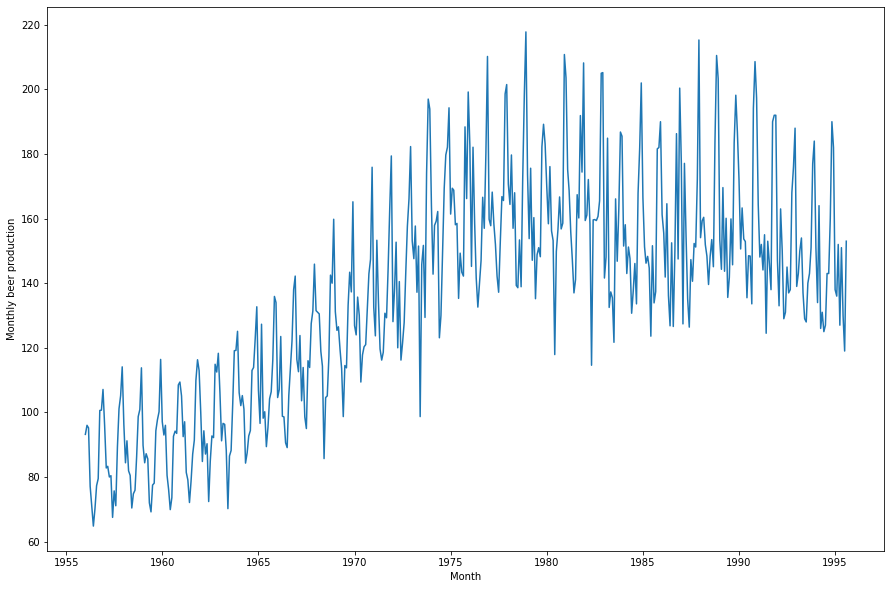

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (15, 10))
ax = sns.lineplot(x = data.index, y = data['Monthly beer production'])

#### Clearly, there is a Trend and Seasonality in the data.
This is why we will use SARIMA or Seasonal ARIMA.

Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

## SARIMA MODEL

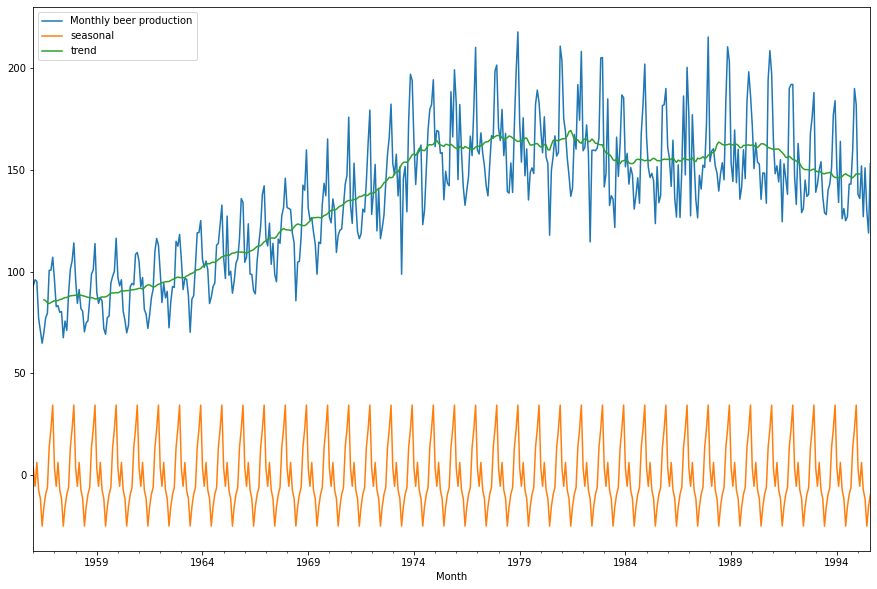

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

ax = seasonal_decompose(data["Monthly beer production"], model = "add")
plt.figure(figsize = (15, 10))
ax.observed.plot()
ax.seasonal.plot()
ax.trend.plot()
plt.legend()

In [7]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data)

(0.01, False)

#### This implies there is no stationarity in the data 

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size = 0.025, shuffle = False)

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(train['Monthly beer production'],
                      order = (2, 1, 1),
                      seasonal_order = (4, 0, 3, 12))

arima_result = arima_model.fit()
arima_result.summary()

D:\ProgramData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1707.666
Date:                                    Mon, 10 Aug 2020   AIC                           3437.332
Time:                                            17:20:16   BIC                           3482.847
Sample:                                        01-01-1956   HQIC                          3455.250
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1198      0.042     -2.845      0.004      -0.202      -0.037
ar.L2         -0.1645      0.045     -3.631      0.000      -0.253      -0.076
ma.L1         -0.8485      0.027    -31.514      0.000      -0.901      -0.796
ar.S.L12       1.7519      0.098     17.856      0.000       1.560       1.944
ar.S.L24      -1.5979      0.189     -8.475      0.000      -1.967      -1.228
ar.S.L36       0.7728      0.145      5.312      0.000       0.488       1.058
ar.S.L48       0.0719      0.050      1.438      0.150      -0.026       0.170
ma.S.L12      -1.5489      0.114    -13.528      0.000      -1.773      -1.324
ma.S.L24       1.3779      0.193      7.156      0.000       1.001       1.755
ma.S.L36      -0.6427      0.113     -5.664      0.000      -0.865      -0.420
sigma2        82.7096      4.765     17.357      0.000      73.370      92.049
===================================================================================
Ljung-Box (Q):                       91.99   Jarque-Bera (JB):                41.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.08   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

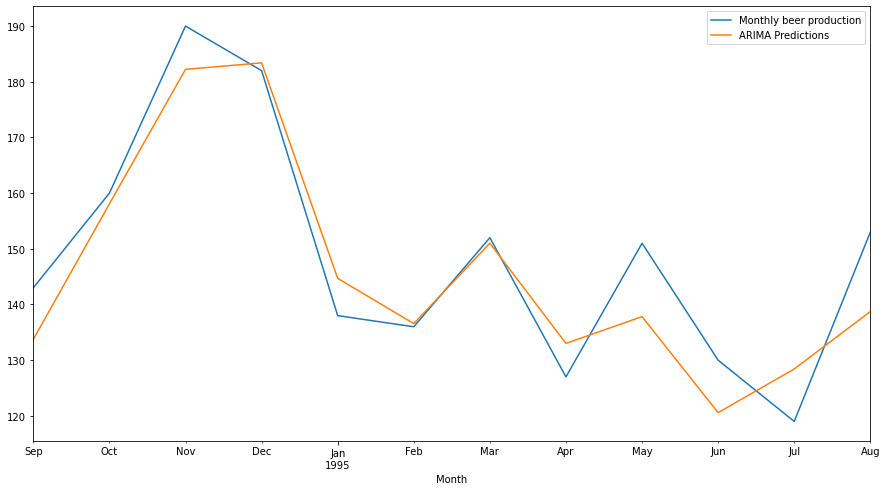

In [10]:
arima_pred = arima_result.predict(start = len(train), end = len(data) - 1, typ = "levels").rename("ARIMA Predictions")
test['ARIMA Predictions'] = arima_pred

test['Monthly beer production'].plot(figsize = (15, 8), legend = True)
test['ARIMA Predictions'].plot(legend = True);

#### These look quite well. Now, we print the MSE, RMSE metrics in order to compare with other models.

In [30]:
from sklearn.metrics import mean_squared_error as mse

MSE_arima = mse(test["Monthly beer production"], arima_pred)
RMSE_arima = (MSE_arima)**(0.5)

print("ARIMA Model :")
print(f'MSE : {MSE_arima}\nRMSE : {RMSE_arima}')

ARIMA Model :
MSE : 65.76061898633121
RMSE : 8.109292138425598


## LSTM MODEL

Let us scale our data before feeding it into an LSTM layer.

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train)
train_sc = sc.transform(train)
test_sc = sc.transform(test)

In [13]:
import tensorflow as tf
import keras
from keras.preprocessing.sequence import TimeseriesGenerator

n_inputs = len(test_sc)
n_features = 1

generator = TimeseriesGenerator(data = train_sc, targets = train_sc,
                                length = n_inputs, batch_size = 1)

Using TensorFlow backend.


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(256, input_shape = (n_inputs, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'loss', patience = 4, verbose = True, mode = 'min')

model.fit_generator(generator, epochs = 20, callbacks = [callback])

Epoch 1/20
452/452 [==============================] - 12s 27ms/step - loss: 0.3314
Epoch 2/20
452/452 [==============================] - 11s 25ms/step - loss: 0.1824
Epoch 3/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1769
Epoch 4/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1786
Epoch 5/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1850
Epoch 6/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1764
Epoch 7/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1678
Epoch 8/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1574
Epoch 9/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1534
Epoch 10/20
452/452 [==============================] - 10s 22ms/step - loss: 0.1495
Epoch 11/20
452/452 [==============================] - 10s 23ms/step - loss: 0.1355
Epoch 12/20
452/452 [==============================] - 11s 24ms/step - loss: 0.1397
E

In [17]:
import numpy as np

batch = (train_sc[-n_inputs:]).reshape((1, n_inputs, n_features))

lstm_pred_sc = []
for i in range(len(test_sc)):
    pred = model.predict(batch)[0]
    lstm_pred_sc.append(pred)
    batch = np.append(batch[:, 1:, :], [[pred]], axis = 1)

In [18]:
lstm_pred = sc.inverse_transform(lstm_pred_sc)
test['LSTM Predictions'] = lstm_pred

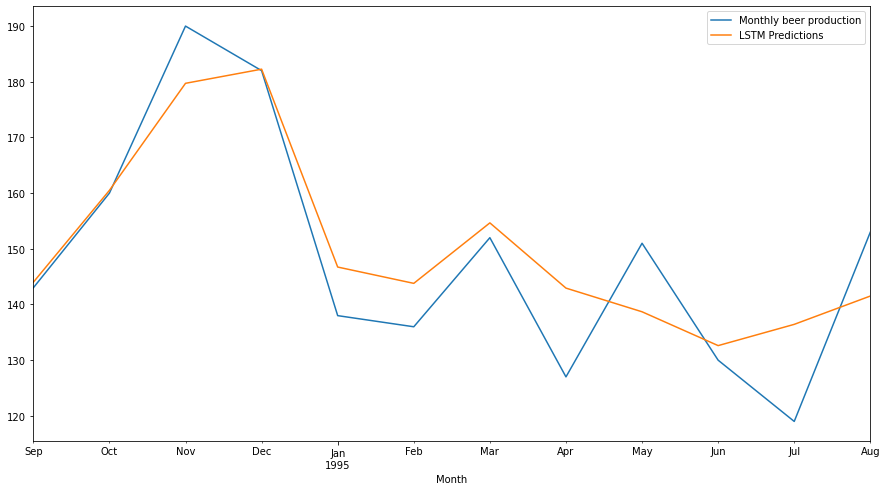

In [19]:
test['Monthly beer production'].plot(figsize = (15, 8), legend = True)
test['LSTM Predictions'].plot(legend = True);

In [31]:
MSE_lstm = mse(test["Monthly beer production"], test["LSTM Predictions"])
RMSE_lstm = (MSE_lstm)**(0.5)

print("LSTM Model :")
print(f'MSE : {MSE_lstm}\nRMSE : {RMSE_lstm}')

LSTM Model :
MSE : 91.5996497105419
RMSE : 9.570770591260763


## Comparison between ARIMA and LSTM models

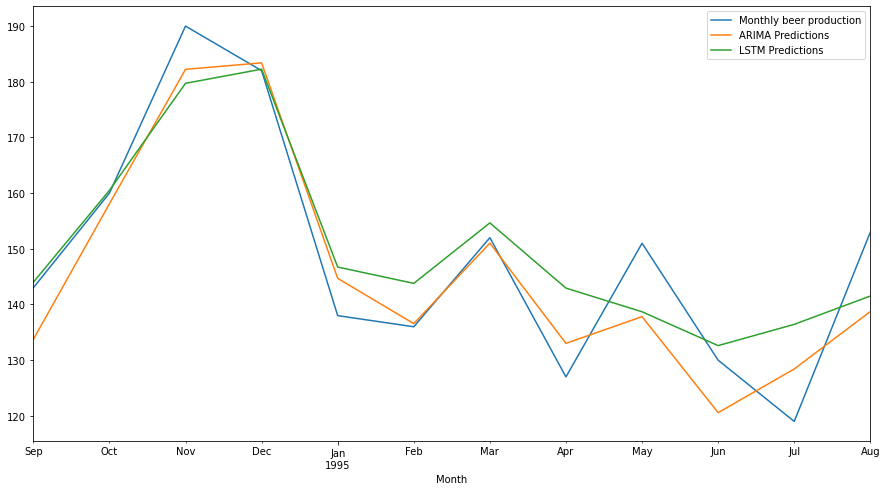

In [26]:
test["Monthly beer production"].plot(figsize = (15, 8), legend = True)
test["ARIMA Predictions"].plot(legend = True);
test["LSTM Predictions"].plot(legend = True);

In [32]:
from tabulate import tabulate

table = [["Models", "MSE", "RMSE"], ["ARIMA", MSE_arima, RMSE_arima], ["LSTM", MSE_lstm, RMSE_lstm]]
print(tabulate(table))

------  -----------------  -----------------
Models  MSE                RMSE
ARIMA   65.76061898633121  8.109292138425598
LSTM    91.5996497105419   9.570770591260763
------  -----------------  -----------------


## We can safely conclude that ARIMA Model has performed pretty well compared to LSTM Model, however it may not always be the case